### 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import pickle
from sklearn.metrics.cluster import adjusted_rand_score

import WEST_plt

file_path = '/home/stat/cai/WEST/data/cancer/'

2024-05-22 16:06:55.504961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 16:06:55.742302: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 16:06:56.799525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-22 16:06:56.799666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### 2. Load data

In [2]:
#### Read data from pickle
with open(file_path+'raw_data.pkl', 'rb') as file:
    adata = pickle.load(file)

### 3. STAGATE function

In [3]:
class GATE():

    def __init__(self, hidden_dims, alpha=0.8, nonlinear=True, weight_decay=0.0001):
        self.n_layers = len(hidden_dims) - 1
        self.alpha = alpha
        self.W, self.v, self.prune_v = self.define_weights(hidden_dims)
        self.C = {}
        self.prune_C = {}
        self.nonlinear = nonlinear
        self.weight_decay = weight_decay

    def __call__(self, A, prune_A, X):
        # Encoder
        H = X
        for layer in range(self.n_layers):
            H = self.__encoder(A, prune_A, H, layer)
            if self.nonlinear:
                if layer != self.n_layers-1:
                    H = tf.nn.elu(H)
        # Final node representations
        self.H = H

        # Decoder
        for layer in range(self.n_layers - 1, -1, -1):
            H = self.__decoder(H, layer)
            if self.nonlinear:
                if layer != 0:
                    H = tf.nn.elu(H)
        X_ = H
        
        # The reconstruction loss of node features
        features_loss = tf.sqrt(tf.reduce_sum(tf.reduce_sum(tf.pow(X - X_, 2))))

        for layer in range(self.n_layers):
            weight_decay_loss = 0
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W[layer]), self.weight_decay, name='weight_loss')

        # Total loss
        self.loss = features_loss  + weight_decay_loss

        if self.alpha == 0:
            self.Att_l = self.C
        else:
            #self.Att_l = {x: (1-self.alpha)*self.C[x] + self.alpha*self.prune_C[x] for x in self.C.keys()}
            self.Att_l = {'C': self.C, 'prune_C': self.prune_C}
        return self.loss, self.H, self.Att_l, X_


    def __encoder(self, A, prune_A, H, layer):
        H = tf.matmul(H, self.W[layer])
        if layer == self.n_layers-1:
            return H
        self.C[layer] = self.graph_attention_layer(A, H, self.v[layer], layer)
        if self.alpha == 0:
            return tf.sparse_tensor_dense_matmul(self.C[layer], H)
        else:
            self.prune_C[layer] = self.graph_attention_layer(prune_A, H, self.prune_v[layer], layer)
            return (1-self.alpha)*tf.sparse_tensor_dense_matmul(self.C[layer], H) + self.alpha*tf.sparse_tensor_dense_matmul(self.prune_C[layer], H)


    def __decoder(self, H, layer):
        H = tf.matmul(H, self.W[layer], transpose_b=True)
        if layer == 0:
            return H
        if self.alpha == 0:
            return tf.sparse_tensor_dense_matmul(self.C[layer-1], H)
        else:
            return (1-self.alpha)*tf.sparse_tensor_dense_matmul(self.C[layer-1], H) + self.alpha*tf.sparse_tensor_dense_matmul(self.prune_C[layer-1], H)


    def define_weights(self, hidden_dims):
        W = {}
        for i in range(self.n_layers):
            W[i] = tf.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        Ws_att = {}
        for i in range(self.n_layers-1):
            v = {}
            v[0] = tf.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
            v[1] = tf.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))

            Ws_att[i] = v
        if self.alpha == 0:
            return W, Ws_att, None
        prune_Ws_att = {}
        for i in range(self.n_layers-1):
            prune_v = {}
            prune_v[0] = tf.get_variable("prune_v%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_v[1] = tf.get_variable("prune_v%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_Ws_att[i] = prune_v

        return W, Ws_att, prune_Ws_att

    def graph_attention_layer(self, A, M, v, layer):

        with tf.variable_scope("layer_%s"% layer):
            f1 = tf.matmul(M, v[0])
            f1 = A * f1
            f2 = tf.matmul(M, v[1])
            f2 = A * tf.transpose(f2, [1, 0])
            logits = tf.sparse_add(f1, f2)

            unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                         values=tf.nn.sigmoid(logits.values),
                                         dense_shape=logits.dense_shape)
            attentions = tf.sparse_softmax(unnormalized_attentions)

            attentions = tf.SparseTensor(indices=attentions.indices,
                                         values=attentions.values,
                                         dense_shape=attentions.dense_shape)

            return attentions

In [4]:
import pandas as pd
import numpy as np
import sklearn.neighbors


def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


def Cal_Spatial_Net_3D(adata, rad_cutoff_2D, rad_cutoff_Zaxis,
                       key_section='Section_id', section_order=None, verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff_2D
        radius cutoff for 2D SNN construction.
    rad_cutoff_Zaxis
        radius cutoff for 2D SNN construction for consturcting SNNs between adjacent sections.
    key_section
        The columns names of section_ID in adata.obs.
    section_order
        The order of sections. The SNNs between adjacent sections are constructed according to this order.
    
    Returns
    -------
    The 3D spatial networks are saved in adata.uns['Spatial_Net'].
    """
    adata.uns['Spatial_Net_2D'] = pd.DataFrame()
    adata.uns['Spatial_Net_Zaxis'] = pd.DataFrame()
    num_section = np.unique(adata.obs[key_section]).shape[0]
    if verbose:
        print('Radius used for 2D SNN:', rad_cutoff_2D)
        print('Radius used for SNN between sections:', rad_cutoff_Zaxis)
    for temp_section in np.unique(adata.obs[key_section]):
        if verbose:
            print('------Calculating 2D SNN of section ', temp_section)
        temp_adata = adata[adata.obs[key_section] == temp_section, ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_2D, verbose=False)
        temp_adata.uns['Spatial_Net']['SNN'] = temp_section
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_2D'] = pd.concat(
            [adata.uns['Spatial_Net_2D'], temp_adata.uns['Spatial_Net']])
    for it in range(num_section-1):
        section_1 = section_order[it]
        section_2 = section_order[it+1]
        if verbose:
            print('------Calculating SNN between adjacent section %s and %s.' %
                  (section_1, section_2))
        Z_Net_ID = section_1+'-'+section_2
        temp_adata = adata[adata.obs[key_section].isin(
            [section_1, section_2]), ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_Zaxis, verbose=False)
        spot_section_trans = dict(
            zip(temp_adata.obs.index, temp_adata.obs[key_section]))
        temp_adata.uns['Spatial_Net']['Section_id_1'] = temp_adata.uns['Spatial_Net']['Cell1'].map(
            spot_section_trans)
        temp_adata.uns['Spatial_Net']['Section_id_2'] = temp_adata.uns['Spatial_Net']['Cell2'].map(
            spot_section_trans)
        used_edge = temp_adata.uns['Spatial_Net'].apply(
            lambda x: x['Section_id_1'] != x['Section_id_2'], axis=1)
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[used_edge, ]
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[:, [
            'Cell1', 'Cell2', 'Distance']]
        temp_adata.uns['Spatial_Net']['SNN'] = Z_Net_ID
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_Zaxis'] = pd.concat(
            [adata.uns['Spatial_Net_Zaxis'], temp_adata.uns['Spatial_Net']])
    adata.uns['Spatial_Net'] = pd.concat(
        [adata.uns['Spatial_Net_2D'], adata.uns['Spatial_Net_Zaxis']])
    if verbose:
        print('3D SNN contains %d edges, %d cells.' %
            (adata.uns['Spatial_Net'].shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %
            (adata.uns['Spatial_Net'].shape[0]/adata.n_obs))

def Stats_Spatial_Net(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Cell1'].shape[0]
    Mean_edge = Num_edge/adata.shape[0]
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
    plot_df = plot_df/adata.shape[0]
    fig, ax = plt.subplots(figsize=[3,2])
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.title('Number of Neighbors (Mean=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df)

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata


In [5]:
import tensorflow.compat.v1 as tf
import scipy.sparse as sp
import numpy as np
# from .model import GATE
from tqdm import tqdm

class STAGATE():

    def __init__(self, hidden_dims, alpha, n_epochs=500, lr=0.0001, 
                 gradient_clipping=5, nonlinear=True, weight_decay=0.0001, 
                 verbose=True, random_seed=2020):
        np.random.seed(random_seed)
        tf.set_random_seed(random_seed)
        self.loss_list = []
        self.lr = lr
        self.n_epochs = n_epochs
        self.gradient_clipping = gradient_clipping
        self.build_placeholders()
        self.verbose = verbose
        self.alpha = alpha
        self.gate = GATE(hidden_dims, alpha, nonlinear, weight_decay)
        self.loss, self.H, self.C, self.ReX = self.gate(self.A, self.prune_A, self.X)
        self.optimize(self.loss)
        self.build_session()

    def build_placeholders(self):
        self.A = tf.sparse_placeholder(dtype=tf.float32)
        self.prune_A = tf.sparse_placeholder(dtype=tf.float32)
        self.X = tf.placeholder(dtype=tf.float32)

    def build_session(self, gpu= True):
        config = tf.compat.v1.ConfigProto() #tf.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = tf.compat.v1.Session(config=config) #tf.Session(config=config)
        # self.session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

        self.session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.local_variables_initializer()])
    

    def optimize(self, loss):
        optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        gradients, variables = zip(*optimizer.compute_gradients(loss))
        gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clipping)
        self.train_op = optimizer.apply_gradients(zip(gradients, variables))

    def __call__(self, A, prune_A, X):
        for epoch in tqdm(range(self.n_epochs)):
            self.run_epoch(epoch, A, prune_A, X)

    def run_epoch(self, epoch, A, prune_A, X):

        loss, _ = self.session.run([self.loss, self.train_op],
                                         feed_dict={self.A: A,
                                                    self.prune_A: prune_A,
                                                    self.X: X})
        self.loss_list.append(loss)
        #if self.verbose:
        #    print("Epoch: %s, Loss: %.4f" % (epoch, loss))
        return loss

    def infer(self, A, prune_A, X):
        H, C, ReX = self.session.run([self.H, self.C, self.ReX],
                           feed_dict={self.A: A,
                                      self.prune_A: prune_A,
                                      self.X: X})

        return H, self.Conbine_Atten_l(C), self.loss_list, ReX

    def Conbine_Atten_l(self, input):
        if self.alpha == 0:
            return [sp.coo_matrix((input[layer][1], (input[layer][0][:, 0], input[layer][0][:, 1])), shape=(input[layer][2][0], input[layer][2][1])) for layer in input]
        else:
            Att_C = [sp.coo_matrix((input['C'][layer][1], (input['C'][layer][0][:, 0], input['C'][layer][0][:, 1])), shape=(input['C'][layer][2][0], input['C'][layer][2][1])) for layer in input['C']]
            Att_pruneC = [sp.coo_matrix((input['prune_C'][layer][1], (input['prune_C'][layer][0][:, 0], input['prune_C'][layer][0][:, 1])), shape=(input['prune_C'][layer][2][0], input['prune_C'][layer][2][1])) for layer in input['prune_C']]
            return [self.alpha*Att_pruneC[layer] + (1-self.alpha)*Att_C[layer] for layer in input['C']]


In [6]:
import numpy as np
import scipy.sparse as sp
import tensorflow.compat.v1 as tf
import pandas as pd
import scanpy as sc

tf.disable_eager_execution()

def train_STAGATE(adata, hidden_dims=[512, 30], alpha=0, n_epochs=500, lr=0.0001, key_added='STAGATE',
                gradient_clipping=5, nonlinear=True, weight_decay=0.0001,verbose=True, 
                random_seed=2020, pre_labels=None, pre_resolution=0.2,
                save_attention=False, save_loss=False, save_reconstrction=False):
    """\
    Training graph attention auto-encoder.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    hidden_dims
        The dimension of the encoder.
    alpha
        The weight of cell type-aware spatial neighbor network.
    n_epochs
        Number of total epochs in training.
    lr
        Learning rate for AdamOptimizer.
    key_added
        The latent embeddings are saved in adata.obsm[key_added].
    gradient_clipping
        Gradient Clipping.
    nonlinear
        If True, the nonlinear avtivation is performed.
    weight_decay
        Weight decay for AdamOptimizer.
    pre_labels
        The key in adata.obs for the manually designate the pre-clustering results. Only used when alpha>0.
    pre_resolution
        The resolution parameter of sc.tl.louvain for the pre-clustering. Only used when alpha>0 and per_labels==None.
    save_attention
        If True, the weights of the attention layers are saved in adata.uns['STAGATE_attention']
    save_loss
        If True, the training loss is saved in adata.uns['STAGATE_loss'].
    save_reconstrction
        If True, the reconstructed expression profiles are saved in adata.layers['STAGATE_ReX'].

    Returns
    -------
    AnnData
    """

    tf.reset_default_graph()
    np.random.seed(random_seed)
    tf.set_random_seed(random_seed)
    if 'highly_variable' in adata.var.columns:
        adata_Vars =  adata[:, adata.var['highly_variable']]
    else:
        adata_Vars = adata
    X = pd.DataFrame(adata_Vars.X.toarray()[:, ], index=adata_Vars.obs.index, columns=adata_Vars.var.index)
    if verbose:
        print('Size of Input: ', adata_Vars.shape)
    cells = np.array(X.index)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    if 'Spatial_Net' not in adata.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")
    Spatial_Net = adata.uns['Spatial_Net']
    G_df = Spatial_Net.copy()
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)
    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata.n_obs, adata.n_obs))
    G_tf = prepare_graph_data(G)

    
    trainer = STAGATE(hidden_dims=[X.shape[1]] + hidden_dims, alpha=alpha, 
                    n_epochs=n_epochs, lr=lr, gradient_clipping=gradient_clipping, 
                    nonlinear=nonlinear,weight_decay=weight_decay, verbose=verbose, 
                    random_seed=random_seed)
    if alpha == 0:
        trainer(G_tf, G_tf, X)
        embeddings, attentions, loss, ReX= trainer.infer(G_tf, G_tf, X)
    else:
        G_df = Spatial_Net.copy()
        if pre_labels==None:
            if verbose:
                print('------Pre-clustering using louvain with resolution=%.2f' %pre_resolution)
            sc.tl.pca(adata, svd_solver='arpack')
            sc.pp.neighbors(adata)
            sc.tl.louvain(adata, resolution=pre_resolution, key_added='expression_louvain_label')
            pre_labels = 'expression_louvain_label'
        prune_G_df = prune_spatial_Net(G_df, adata.obs[pre_labels])
        prune_G_df['Cell1'] = prune_G_df['Cell1'].map(cells_id_tran)
        prune_G_df['Cell2'] = prune_G_df['Cell2'].map(cells_id_tran)
        prune_G = sp.coo_matrix((np.ones(prune_G_df.shape[0]), (prune_G_df['Cell1'], prune_G_df['Cell2'])))
        prune_G_tf = prepare_graph_data(prune_G)
        prune_G_tf = (prune_G_tf[0], prune_G_tf[1], G_tf[2])
        trainer(G_tf, prune_G_tf, X)
        embeddings, attentions, loss, ReX = trainer.infer(G_tf, prune_G_tf, X)
    cell_reps = pd.DataFrame(embeddings)
    cell_reps.index = cells

    adata.obsm[key_added] = cell_reps.loc[adata.obs_names, ].values
    if save_attention:
        adata.uns['STAGATE_attention'] = attentions
    if save_loss:
        adata.uns['STAGATE_loss'] = loss
    if save_reconstrction:
        ReX = pd.DataFrame(ReX, index=X.index, columns=X.columns)
        ReX[ReX<0] = 0
        adata.layers['STAGATE_ReX'] = ReX.values
    return adata


def prune_spatial_Net(Graph_df, label):
    print('------Pruning the graph...')
    print('%d edges before pruning.' %Graph_df.shape[0])
    pro_labels_dict = dict(zip(list(label.index), label))
    Graph_df['Cell1_label'] = Graph_df['Cell1'].map(pro_labels_dict)
    Graph_df['Cell2_label'] = Graph_df['Cell2'].map(pro_labels_dict)
    Graph_df = Graph_df.loc[Graph_df['Cell1_label']==Graph_df['Cell2_label'],]
    print('%d edges after pruning.' %Graph_df.shape[0])
    return Graph_df


def prepare_graph_data(adj):
    # adapted from preprocess_adj_bias
    num_nodes = adj.shape[0]
    adj = adj + sp.eye(num_nodes)# self-loop
    #data =  adj.tocoo().data
    #adj[adj > 0.0] = 1.0
    if not sp.isspmatrix_coo(adj):
        adj = adj.tocoo()
    adj = adj.astype(np.float32)
    indices = np.vstack((adj.col, adj.row)).transpose()
    return (indices, adj.data, adj.shape)

def recovery_Imputed_Count(adata, size_factor):
    assert('ReX' in adata.uns)
    temp_df = adata.uns['ReX'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count'] = temp_df
    return adata


### 4. Preprocess

In [7]:
max(adata.obs['loc_x']) - min(adata.obs['loc_x'])

28

------Calculating spatial graph...
The graph contains 1524 edges, 428 cells.
3.5607 neighbors per cell on average.


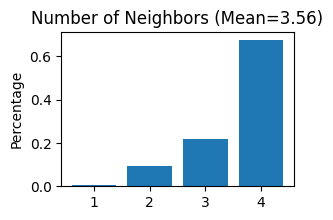

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4) # Normalization
sc.pp.log1p(adata) # Take log
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True) # Gene screening
adata.obsm['spatial'] = adata.obs[['loc_x', 'loc_y']].to_numpy()
#### Construct spatial network
Cal_Spatial_Net(adata, rad_cutoff=1)
Stats_Spatial_Net(adata)

### 5. Model training

In [9]:
import tensorflow.compat.v1 as tf
from scipy.sparse import csr_matrix
tf.disable_eager_execution()
adata.X = csr_matrix(adata.X)
adata = train_STAGATE(adata, alpha=0)

Size of Input:  (428, 2000)


2024-05-22 16:07:37.208528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 16:07:41.121897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21622 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2024-05-22 16:07:41.124491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 27632 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2024-05-22 16:07:41.125783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device

### 6. Clustering

In [10]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)
adata = mclust_R(adata, used_obsm='STAGATE', num_cluster=4)
ARI = adjusted_rand_score(adata.obs['mclust'], adata.obs['true cluster']) 
print('ARI: ', ARI)
print(adata.obs['mclust'].unique())

/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
ARI:  0.5473133562575203
[1, 2, 3, 4]
Categories (4, int64): [1, 2, 3, 4]


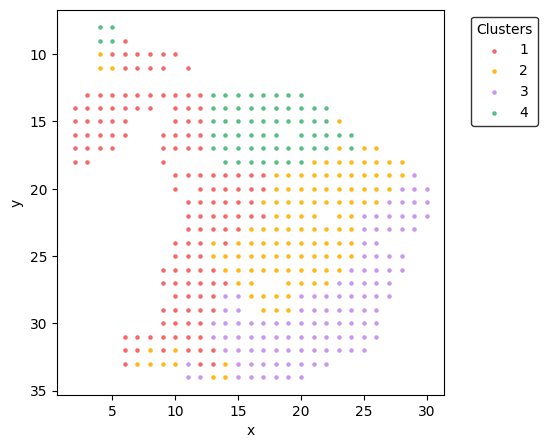

In [11]:
WEST_plt.WEST_scatter(adata, reps='mclust', invert_y=True, s=5)

In [21]:
adata.X.shape

(2500, 400)

### 7. Save embedding

In [12]:
np.savetxt(file_path+'STAGATE_embedding.csv', adata.obsm['STAGATE'], delimiter=',')
np.savetxt(file_path+'STAGATE_cluster.csv', adata.obs['mclust'], delimiter=',', fmt='%s')